<a href="https://colab.research.google.com/github/sac-1999/CNN-Architectures/blob/main/Alexnet_oncifar_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import tensorflow.keras.layers as layers
from tqdm import tqdm

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_validation,y_train,y_validation = train_test_split(x_train,y_train, test_size = 5000, random_state = 0)

In [ ]:
train_csv = pd.DataFrame(y_train, columns = ['label'])
train_csv['index'] = train_csv.index
train_csv = train_csv.astype({'index': np.str})
train_csv['image_ids'] = 'image_' + train_csv['index'] + '.png'
train_csv.drop(labels = 'index', inplace = True, axis = 1)

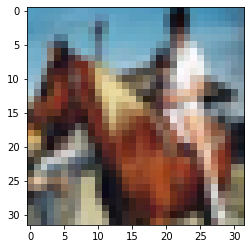

In [ ]:
plt.imshow(x_validation[0])

In [ ]:
def save_to_local(data, path):
    dims = (227,227)
    for i in tqdm(range(len(data))):
        image = data[i]
        image = tf.image.resize(image, dims)
        image = tf.cast(image, tf.uint8).numpy()
        plt.imsave(path + 'image_'+ str(i) + '.png', image)

In [ ]:
train_path = '/content/drive/MyDrive/local_data/train/'
test_path = '/content/drive/MyDrive/local_data/test/'
validation_path = '/content/drive/MyDrive/local_data/validation/'

In [ ]:
os.mkdir(train_path)
os.mkdir(test_path)
os.mkdir(validation_path)

In [ ]:
save_to_local(x_train,train_path)

100%|██████████| 45000/45000 [25:20<00:00, 29.59it/s]


In [ ]:
save_to_local(x_test,test_path)
save_to_local(x_validation,validation_path)

100%|██████████| 5000/5000 [02:48<00:00, 29.72it/s]


In [ ]:
file_path = train_csv['image_ids'].values
labels = train_csv['label'].values

In [ ]:
ds_train = tf.data.Dataset.from_tensor_slices((file_path,labels))

In [ ]:
def read_image(image_path,label):
    image = tf.io.read_file(train_path + image_path)
    image = tf.image.decode_image(image,channels = 3, dtype = tf.dtypes.float32)
    return image,label

In [ ]:
ds_train = ds_train.map(read_image)

In [ ]:
ds_train

<MapDataset shapes: (<unknown>, ()), types: (tf.float32, tf.uint8)>

In [ ]:
ds_train = (ds_train.shuffle(buffer_size=tf.data.experimental.cardinality(ds_train).numpy())
            .batch(batch_size = 8, drop_remainder=True))

In [ ]:
'''test_dataset = (test_dataset
                  .shuffle(buffer_size=tf.data.experimental.cardinality(test_dataset).numpy())
                  .batch(batch_size=32, drop_remainder=True))'''

'test_dataset = (test_dataset\n                  .shuffle(buffer_size=tf.data.experimental.cardinality(test_dataset).numpy())\n                  .batch(batch_size=32, drop_remainder=True))'

In [ ]:
'''validation_dataset = (validation_dataset
                  .shuffle(buffer_size=tf.data.experimental.cardinality(validation_dataset).numpy())
                  .batch(batch_size=32, drop_remainder=True))'''

'validation_dataset = (validation_dataset\n                  .shuffle(buffer_size=tf.data.experimental.cardinality(validation_dataset).numpy())\n                  .batch(batch_size=32, drop_remainder=True))'

In [ ]:
def create_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(filters = 96, kernel_size = 11, strides = (4,4), padding = 'valid', activation = 'relu',
                            input_shape=(227,227,3),name= 'conv_1_layer'))
    layers.BatchNormalization()
    model.add(layers.MaxPool2D(pool_size = (2,2),strides = (2,2),name = 'pool_1'))

    model.add(layers.Conv2D(filters = 256, kernel_size = 5, strides = (1,1), padding = 'same', activation = 'relu', name= 'conv_2_layer'))
    layers.BatchNormalization()
    model.add(layers.MaxPool2D(pool_size = (3,3),strides = (2,2), name = 'pool_2'))


    model.add(layers.Conv2D(filters = 384, kernel_size = 3, strides = (1,1), padding = 'same', activation = 'relu', name= 'conv_3_layer'))
    layers.BatchNormalization()
    model.add(layers.Conv2D(filters = 384, kernel_size = 3, strides = (1,1), padding = 'same', activation = 'relu', name= 'conv_4_layer'))
    layers.BatchNormalization()
    model.add(layers.Conv2D(filters = 256, kernel_size = 3, strides = (1,1), padding = 'same', activation = 'relu', name= 'conv_5_layer'))
    layers.BatchNormalization()

    model.add(layers.MaxPool2D(pool_size = (3,3),strides = (2,2), name ='pool_3'))

    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(4096, activation='softmax'))
    return model


In [ ]:
model = create_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1_layer (Conv2D)        (None, 55, 55, 96)        34944     
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 27, 27, 96)        0         
_________________________________________________________________
conv_2_layer (Conv2D)        (None, 27, 27, 256)       614656    
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 13, 13, 256)       0         
_________________________________________________________________
conv_3_layer (Conv2D)        (None, 13, 13, 384)       885120    
_________________________________________________________________
conv_4_layer (Conv2D)        (None, 13, 13, 384)       1327488   
_________________________________________________________________
conv_5_layer (Conv2D)        (None, 13, 13, 256)       8

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])


In [ ]:
model.fit(ds_train,
          epochs=1,
          verbose= 2)